In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../scripts/results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import re

evalTime = 25.

In [40]:
def getVal(mypath, filename,dtype=float,extension='.txt', header="infer",names = None):
    
    fullpath = pathresults +mypath+filename
    data_file_delimiter = ","
    if names is None:
        largest_column_count = 0
        with open(fullpath, 'r') as temp_f:
            lines = temp_f.readlines()
        last_line = lines[-1].strip()
        #print('last_line',last_line)
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        largest_column_count = len(array_from_last_line)
        names = [i for i in range(0, largest_column_count)]
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, 
                          header = header, names = names)
        #print('cst',cst.shape)
    else:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header, names = names)
    return cst
    
def get_last_line_as_numpy_array(file_path,  dtype = float, verbose = False):
    with open(pathresults +file_path, 'r') as file:
        # Read all lines
        lines = file.readlines()

        # Check if there are any lines in the file
        if not lines:
            raise ValueError("The file is empty")

        # Get the last line
        
        try:
            last_line = lines[-1].strip()
        except:
            print('timeLine',file_path, len(lines))
            raise Exception

        # Split the last line by commas and convert to NumPy array
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        if verbose:
            print(file_path, len(array_from_last_line), end=", ")

        return array_from_last_line

def getCylIdx(path2file):
    fileName = "rhizoSegsId.txt"
    fullpath = path2file+fileName
    rhizoSegsId = get_last_line_as_numpy_array(fullpath, dtype = int, verbose = True)
    print('rhizoSegsId',max(rhizoSegsId))
    return rhizoSegsId
    
def list_files_with_prefix(folder_path, prefix):
    file_names = []
    for file_name in os.listdir(pathresults+folder_path):
        if file_name.startswith(prefix):
            file_names.append(file_name)
    return file_names

# cylinder max konz (per cell)
def getData_(cid,gId,path2file):
    fileName = "cyl_val/Cyl_cellVol_"+str(gId)+".txt"
    cVol = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
    if cid == volIdx:
        return sum(cVol)
    elif cid <= 9:
        if cid <= 2:# == 0:
            fileName = "cyl_val/Cyl_watercontent_"+str(gId)+".txt"
            theta = get_last_line_as_numpy_array(path2file+fileName,dtype = float)
            cVol *= theta#cm3 scv to cm3 water
            if cid == 0:
                return sum(cVol)
        fileName = "cyl_val/Cyl_content"+str(cid)+"_"+str(gId)+".txt"
        Q1 = get_last_line_as_numpy_array(path2file+fileName,  dtype = float)
        konz = sum(Q1)/sum(cVol) #mol/cm3 or cm3/cm3
        return konz
    raise Exception

plantData = {0:'seg_fluxes1Cumul',1:'seg_fluxes2Cumul',2:'seg_fluxes0Cumul',
             3:'time',
             4:'pSet'}

extensions = {0:'.csv',1:'.csv',2:'.csv',3: '.txt', 4:'.txt',
             5:'.txt',
             6:'.txt', 7:'.txt',8:'.txt', 9:'.txt', 10:'.txt',
              11:'.txt',12:'.txt',13:'.txt'}
colNames=np.array(list(plantData.values()))
nToGet = len(plantData)-2 # all except pset and scenario

setIds =[0,1,2,3]# ,44,49 [7,21, 47, 85]


def getData():
    
    GiniAll = [[] for i in range(len(setIds))]
    
    for idSet, dI in enumerate([0]):
        GiniAll_ = pd.DataFrame(columns=colNames)
        print(dI,end =", ")

        path2file = path2file_#.format(dI)
        #print(path2file)

        time = np.array(list(
            pd.read_csv(pathresults + path2file + "time.txt", 
                           names = ["time","Qlight"])["time"][1:])) # because we have twice the initial value
        timemax = int((max(time))*10)/10
        #print('timemax',max(time),timemax, len(time))

        for cid in range(nToGet):
            if plantData[cid] == 'psiXyl':
                Ginits = getVal(path2file,plantData[cid]+extensions[cid]
                        ).mean(axis=1)
            else:
                Ginits = getVal(path2file,plantData[cid]+extensions[cid]
                        ).sum(axis=1)
            #print(plantData[cid])#,Ginits,type(Ginits))
            GiniAll_[plantData[cid]]= Ginits
            
        GiniAll_[plantData[nToGet]]= time[:len(GiniAll_[plantData[nToGet]])]
        GiniAll_[plantData[nToGet+1]]= dI
        print(plantData[nToGet+1], dI)
        GiniAll[idSet] = GiniAll_
    return GiniAll #cid pSet rr

In [52]:

path2file_ = "tillage/cumuseg400tr_90_25to25_1mn_0s_33/" #r'pdef/{}baseline_1440_10to25_20mn_0s_32/'
path2file_ = "tillage/cumuseg12tr_90_25to25_1mn_0s_33/"
GiniAll = getData()

0, pSet 0


In [53]:

dftemp=[]
for Gini in GiniAll:
    dftemptemp=pd.DataFrame(Gini)
    dftemp.append(dftemptemp)

In [54]:
result = pd.concat(dftemp)

In [55]:
result.columns

Index(['seg_fluxes1Cumul', 'seg_fluxes2Cumul', 'seg_fluxes0Cumul', 'time',
       'pSet'],
      dtype='object')

In [56]:
pset=result['pSet'].to_numpy()

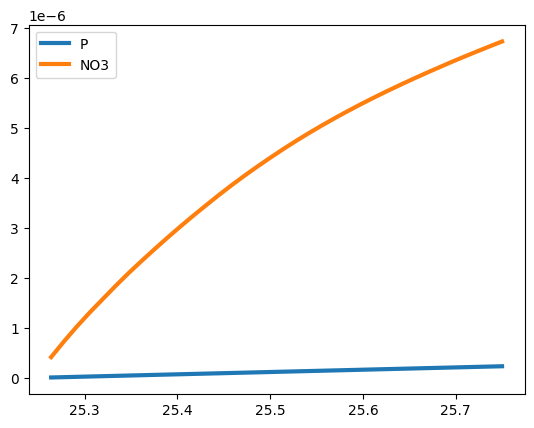

In [57]:
for cc in [0]:
    dd = result#[cc]
    #plt.plot( dd['time'],-dd['seg_fluxes0Cumul'],
    #                                                             linewidth=3,
    #                         label=f'Water')
    plt.plot( dd['time'],-dd['seg_fluxes1Cumul'],
                                                                 linewidth=3,
                             label=f'P')
    plt.plot( dd['time'],-dd['seg_fluxes2Cumul'],
                                                                 linewidth=3,
                             label=f'NO3')
plt.legend()
plt.show()

In [68]:
file_names = [name for name in os.listdir(pathresults + path2file_+'cyl_val') ]#if name[:len('Cyl_time')] == 'Cyl_time' ] # repetitions of same genotype


In [69]:
file_names

['Cyl_time_877.txt',
 'Cyl_time_555.txt',
 'Cyl_time_371.txt',
 'Cyl_time_1429.txt',
 'Cyl_time_647.txt',
 'Cyl_time_1337.txt',
 'Cyl_time_1475.txt',
 'Cyl_time_509.txt',
 'Cyl_time_601.txt',
 'Cyl_time_1245.txt',
 'Cyl_time_1061.txt',
 'Cyl_time_47.txt',
 'Cyl_time_233.txt',
 'Cyl_time_969.txt',
 'Cyl_time_785.txt',
 'Cyl_time_141.txt',
 'Cyl_time_94.txt',
 'Cyl_time_417.txt',
 'Cyl_time_693.txt',
 'Cyl_time_1383.txt',
 'Cyl_time_1153.txt',
 'Cyl_time_1291.txt',
 'Cyl_time_831.txt',
 'Cyl_time_463.txt',
 'Cyl_time_1107.txt',
 'Cyl_time_1199.txt',
 'Cyl_time_1015.txt',
 'Cyl_time_325.txt',
 'Cyl_time_739.txt',
 'Cyl_time_923.txt',
 'Cyl_time_187.txt',
 'Cyl_time_279.txt',
 'Cyl_watercontent_877.txt',
 'Cyl_watercontent_601.txt',
 'Cyl_watercontent_1061.txt',
 'Cyl_watercontent_555.txt',
 'Cyl_watercontent_1245.txt',
 'Cyl_watercontent_233.txt',
 'Cyl_watercontent_47.txt',
 'Cyl_watercontent_969.txt',
 'Cyl_watercontent_785.txt',
 'Cyl_watercontent_94.txt',
 'Cyl_watercontent_417.txt',


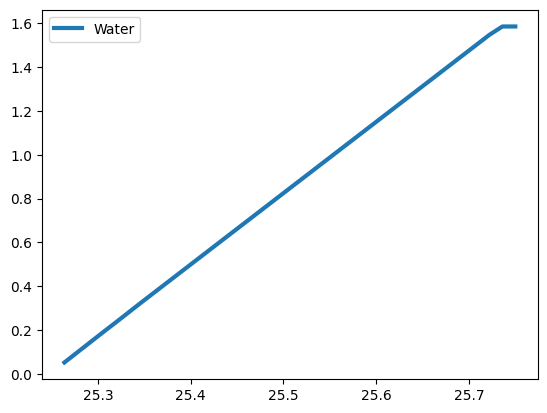

In [58]:
for cc in [0]:
    dd = result#[cc]
    plt.plot( dd['time'],-dd['seg_fluxes0Cumul'],
                                                                 linewidth=3,
                             label=f'Water')
plt.legend()
plt.show()

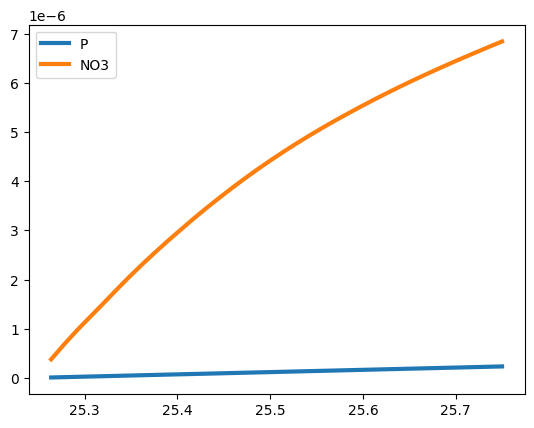

In [47]:
for cc in [0]:
    dd = result#[cc]
    #plt.plot( dd['time'],-dd['seg_fluxes0Cumul'],
    #                                                             linewidth=3,
    #                         label=f'Water')
    plt.plot( dd['time'],-dd['seg_fluxes1Cumul'],
                                                                 linewidth=3,
                             label=f'P')
    plt.plot( dd['time'],-dd['seg_fluxes2Cumul'],
                                                                 linewidth=3,
                             label=f'NO3')
plt.legend()
plt.show()

# add trans + rsx

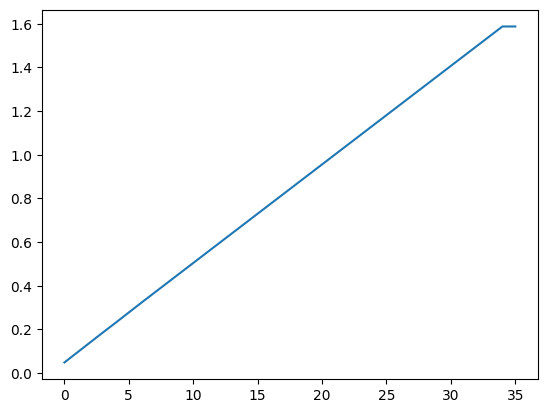

In [51]:
plt.plot(-np.array(trans))

In [21]:

from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
l_styles = {5:'-',44:'-.',61:':'}
# Define the color dictionary
c_styles = {
    0:'k',  # Blue
    1:'#377EB8',  # Blue
    2:  '#4DAF4A' ,  # Green
    3: '#E41A1C'  # red
}
color_legend_elements = [
    Line2D([0], [0], color=c_styles[0], lw=2, label='P0'),
    Line2D([0], [0], color=c_styles[1], lw=2, label='P1'),
    Line2D([0], [0], color=c_styles[2], lw=2, label='P2'),
    Line2D([0], [0], color=c_styles[3], lw=2, label='P3')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=2, label=5),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=2, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=2, label=44),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=2, label=61)
]

def dotheplot(toplot, cumsum,df, sizerows,sizecols_,namesyaxes=None,ncols=3, maxTime = None, indexlegend1=0, indexlegend2=1):

    fig, ax = plt.subplots(1, 1,figsize=(15,15)) 
    
    for ddid, dd in enumerate(df):
        for rowid, tipi in enumerate(toplot): 
            try:
                pset_ = int(dd['pSet'].unique()[0])
            except:
                print('rowid', rowid,tipi)
                print(dd['pSet'].unique())
            scenario_ = "baseline"
            if ncols > 1:
                colid = np.where(scenario_==np.array(scenarios))[0][0]
            else:
                colid = 0
            factor = 1000
            rot = 0
            unit=" (mmol C)"
            if (tipi == "trans" )or (tipi =='psiXyl'):
                factor = cm3tommol
                unit = " (cm3)"

            if tipi == "psiXyl":
                factor = 1.
                rot =30
            ddd = dd[tipi]*factor
            tts = dd['time']
            if not cumsum:
                tts = dd['time'][1:]
                ddd = np.diff(ddd)*4

            if ncols > 1:
                ax_ = ax[rowid, colid]
            else:
                ax_ = ax[rowid]
            ax_.plot( tts,ddd,
                                                             linewidth=3,
                         #label=f'{i}',
                         c=c_styles[dd['scenario'].unique()[0]],
                         linestyle=l_styles[int(dd['pSet'].unique()[0])])


            ax_.tick_params(axis='both', which='major', labelsize=18)
            ax_.tick_params(axis='y', which='major', labelrotation=rot, labelsize=18)
            if colid == 0:
                if namesyaxes is not None:
                    ax_.set_ylabel(namesyaxes[tipi]+unit, fontsize=20)
                else:
                    ax_.set_ylabel(tipi+unit, fontsize=20)
            if rowid == 0 and ncols > 1:
                ax_.set_title(scenario_)
            if rowid == nrows-1:
                ax_.set_xlabel('time (d)', fontsize=20)
            if True:
                if scenario_ == "lateDry":
                    ax_.axvline(x=18, color='k', linestyle='--')
                    ax_.axvline(x=25, color='k', linestyle='--')
                if scenario_ == "earlyDry":
                    ax_.axvline(x=18, color='k', linestyle='--')
                    ax_.axvline(x=11, color='k', linestyle='--')
            if maxTime is not None:
                ax_.set_xlim(10, maxTime)

            if rowid + colid == indexlegend1:
                ax_.legend(handles=color_legend_elements, 
                                                           fontsize=20,title_fontsize='25', title='scenario', 
                                                           loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.15),

            if rowid + colid == indexlegend2:
                ax_.legend(handles=linestyle_legend_elements, 
                                                           fontsize=20,title_fontsize='25', title='parameter set', 
                                                           loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.3),
                if False:

                    ax_.add_artist(plt.legend(handles=color_legend_elements, 
                                                                              fontsize=20, title='scenario', 
                                                                               title_fontsize='25',
                                                                              loc='upper center',# bbox_to_anchor=anchor1,#(0.5, -0.15), 
                                                                              ncol=3, framealpha=1))
                    ax_.add_artist(plt.legend(handles=linestyle_legend_elements, 
                                                                              fontsize=20, title='parameter set', 
                                                                               title_fontsize='25',
                                                                              loc='upper center',# bbox_to_anchor=anchor2,#(0.5, -0.3), 
                                                                              ncol=3, framealpha=1))

                #ax_.legend() 

    plt.tight_layout()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

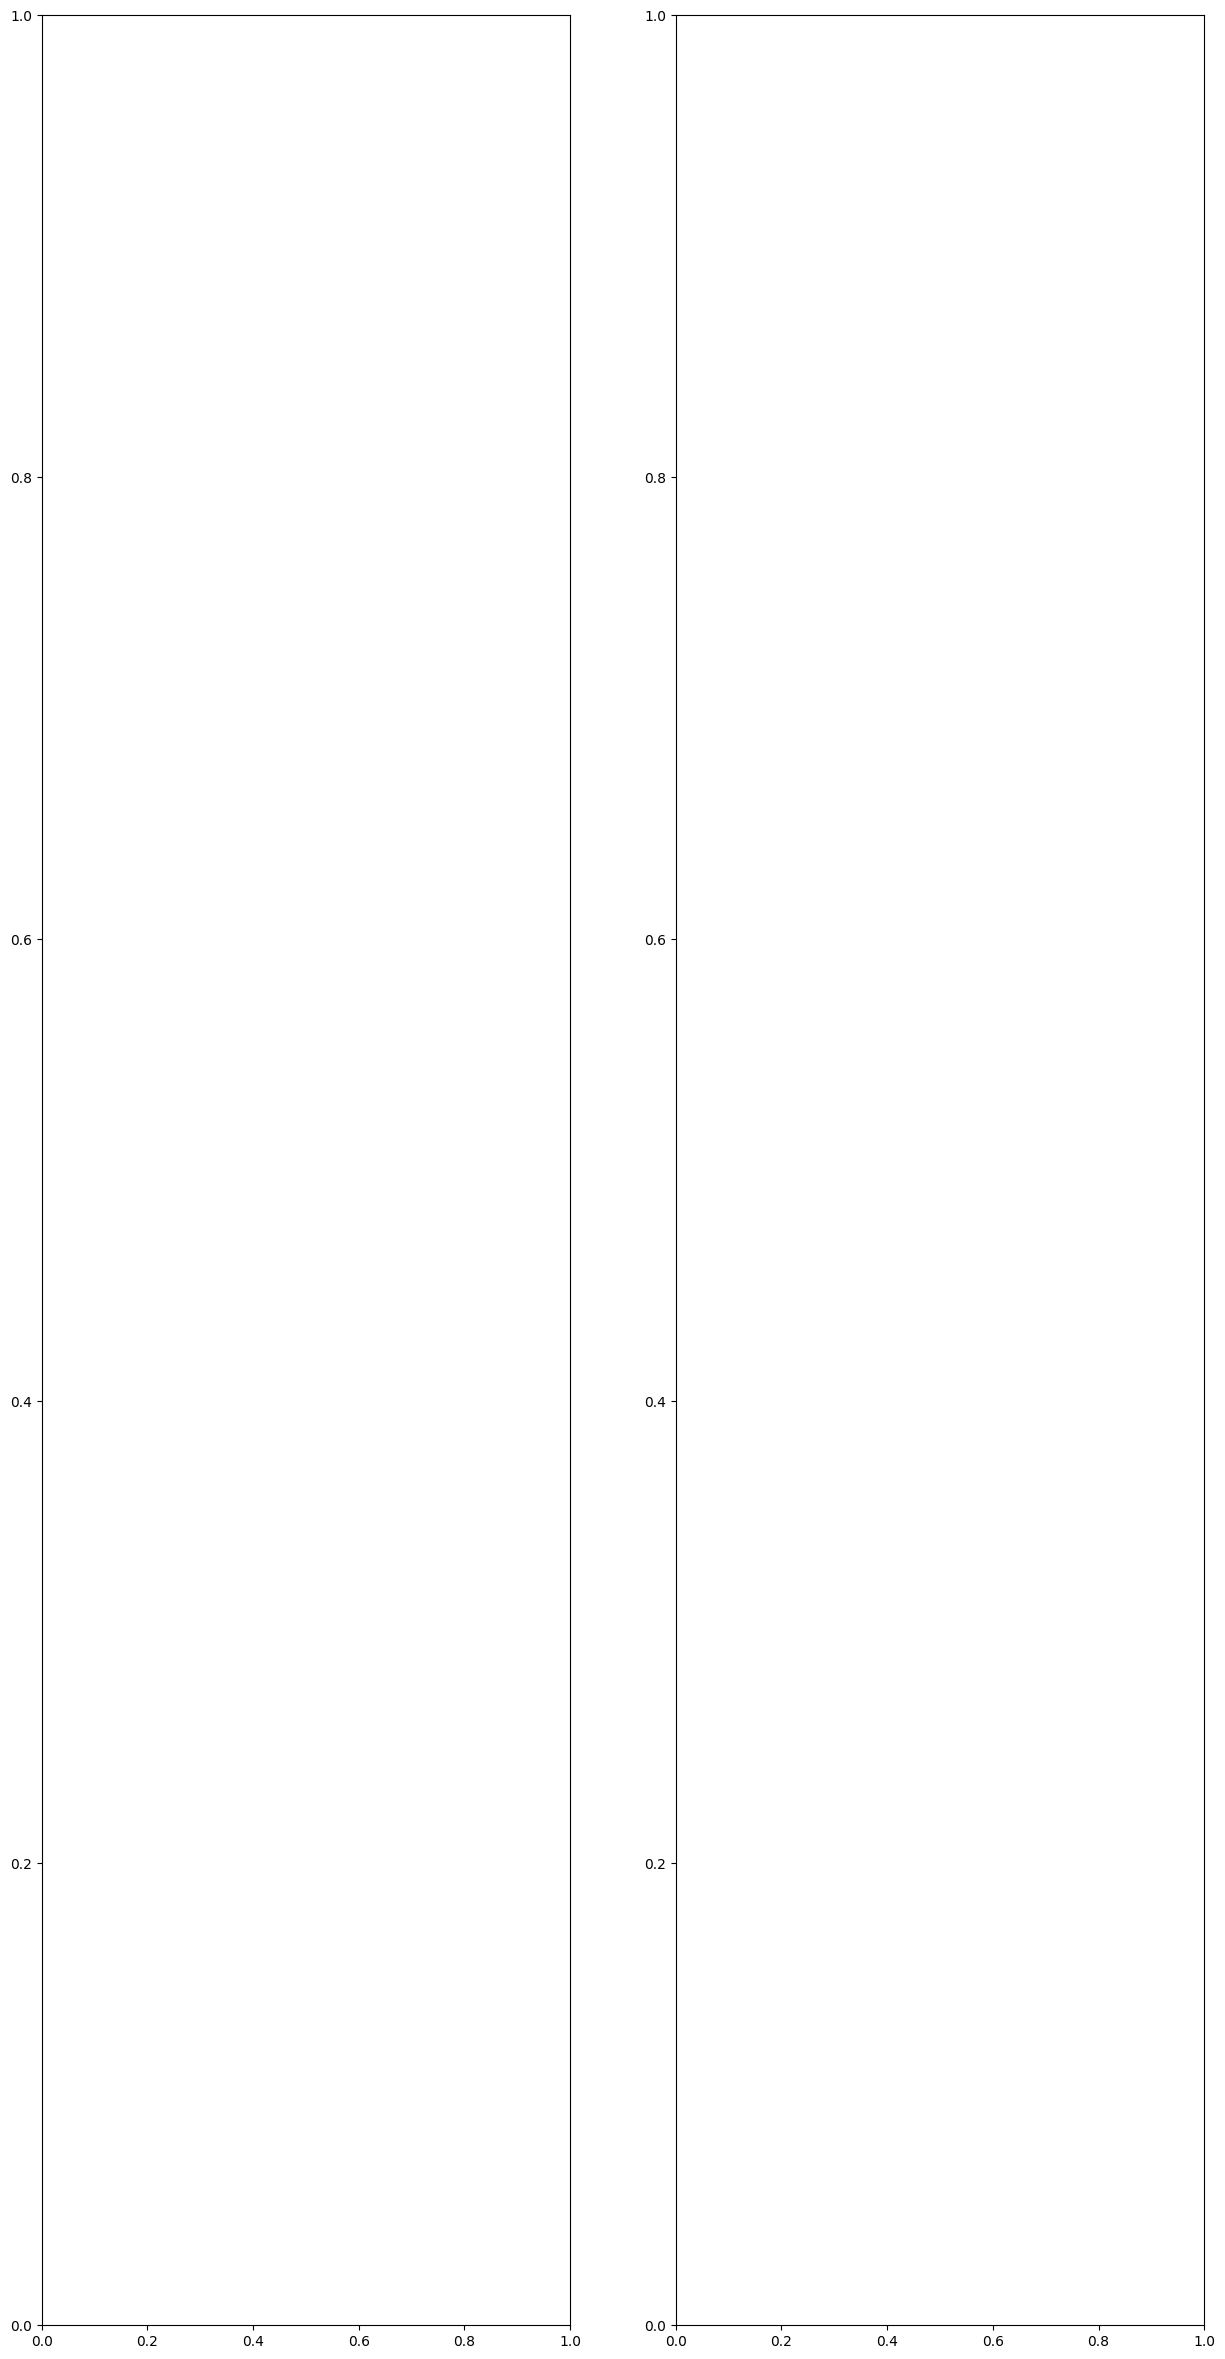

In [23]:

dotheplot(toplot =  ['seg_fluxes1Cumul'],
          namesyaxes={'seg_fluxes1Cumul':"PPU"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=2, indexlegend1=2, indexlegend2=3)

In [12]:
Qx = get_last_line_as_numpy_array(
    r'pdef/0baseline_1440_10to25_20mn_0s_32/cyl_val/'+'Cyl_coord_0.txt',  dtype = float)
Qy = get_last_line_as_numpy_array(
    r'pdef/0baseline_1440_10to25_20mn_0s_32/cyl_val/'+'Cyl_content1_0.txt',  dtype = float)
Qvol = get_last_line_as_numpy_array(
    r'pdef/0baseline_1440_10to25_20mn_0s_32/cyl_val/'+'Cyl_cellVol_0.txt',  dtype = float)

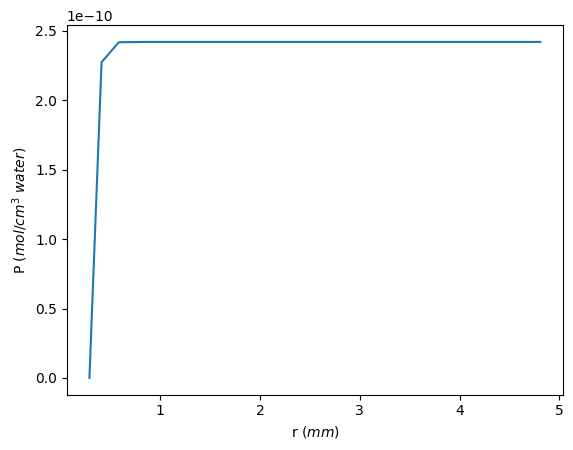

In [18]:
plt.plot(Qx*10.,Qy/Qvol)
plt.ylabel('P ($mol/cm^3~water$)')
plt.xlabel('r ($mm$)')
plt.show()